<a href="https://colab.research.google.com/github/10Exahertz/Text-ResNet-on-Sentimental-LIAR-Fake-News/blob/main/Sentimental_LIAR_4_Layer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is the code for the paper: https://arxiv.org/abs/2009.01047

Sentimental LIAR: Extended Corpus and Deep Learning Models for Fake Claim Classification

The code is for the best performing model where the TEXT is passed into BERT-base and the output of the BERT-base is concatenated with EMO, SPC and SEN and then passed to the CNN. The model achieved the accuracy of 70% and F1 Macro Score of 0.6430

In [ ]:
!pip install -q transformers
!pip install sentencepiece

     |████████████████████████████████| 2.1MB 5.8MB/s 
     |████████████████████████████████| 901kB 24.8MB/s 
     |████████████████████████████████| 3.3MB 55.3MB/s 
     |████████████████████████████████| 1.2MB 5.5MB/s 


In [ ]:

import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/train_final.csv")
df_test=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/test_final.csv")
df_valid=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/valid_final.csv")
print("before truncating size of data is :", df.shape, df_test.shape,df_valid.shape)
df=df[:10232] #10208
df_test=df_test[:1264] #1248
df_valid=df_valid[:1280] #1280
print("size of data is :", df.shape, df_test.shape, df_valid.shape)


#check if any null values are present
print("Any null in Subject? ",df['subject'].isnull().values.any())
print("Any null in Speaker? ",df['speaker'].isnull().values.any())
print("Any null in speaker_job? ",df['speaker_job'].isnull().values.any())
print("Any null in Party? ",df['party_affiliation'].isnull().values.any())
print("Any null in Context? ",df['context'].isnull().values.any())


def listV2Out(inputLabel):
  if inputLabel == 'pants-fire':
    return '[1,0,0,0,0]'
  if inputLabel == 'false':
    return '[0,1,0,0,0]'
  if inputLabel == 'barely-true':
    return '[0,0,1,0,0]'
  if inputLabel == 'half-true':
    return '[0,0,0,1,0]'
  if inputLabel == 'mostly-true':
    return '[0,0,0,0,1]'
  if inputLabel == 'true':
    return '[0,0,0,0,1]'
pd.set_option('display.max_columns', None)
df['listV2'] = 0
for i in range(len(df)):
  df.loc[i,'listV2'] = listV2Out(df.loc[i,'label'])
df_test['listV2'] = 0
for i in range(len(df_test)):
  df_test.loc[i,'listV2'] = listV2Out(df_test.loc[i,'label'])
df_valid['listV2'] = 0
for i in range(len(df_valid)):
  df_valid.loc[i,'listV2'] = listV2Out(df_valid.loc[i,'label'])

print("Any null in ListV2? ",df['listV2'].isnull().values.any())


before truncating size of data is : (10236, 31) (1267, 30) (1283, 31)
size of data is : (10232, 31) (1264, 30) (1280, 31)
Any null in Subject?  False
Any null in Speaker?  False
Any null in speaker_job?  True
Any null in Party?  False
Any null in Context?  True
Any null in ListV2?  False


In [ ]:

df['comment_text']=""
df_test['comment_text']=""
df_valid["comment_text"]=""

#combine all the columns into one for train, test and valid data

# df['comment_text']=df['subject'].astype(str)+ ". "+ df["statement"]+\
# df['speaker_id'].astype(str)+". "+df['speaker_job'].astype(str)+". "+ df['party_affiliation'].astype(str)\
# +". "+df['context'].astype(str)+". "+df['sentiment_code'].astype(str)
df['comment_text']= df["statement"]+". "+df['sentiment_code'].astype(str)

# df_test['comment_text']=df_test['subject'].astype(str)+ ". "+ df_test["statement"]+". "+\
# df_test['speaker_id'].astype(str)+". "+df_test['speaker_job'].astype(str)+". "+ df_test['party_affiliation'].astype(str)\
# +". "+df_test['context'].astype(str)+". "+df['sentiment_code'].astype(str)
df_test['comment_text']= df_test["statement"]+". "+df_test['sentiment_code'].astype(str)

# df_valid['comment_text']=df_valid['subject'].astype(str)+ ". "+ df_valid["statement"]+\
# df_valid['speaker_id'].astype(str)+". "+df_valid['speaker_job'].astype(str)+". "+ df_valid['party_affiliation'].astype(str)\
# +". "+df_valid['context'].astype(str)+". "+df_valid['sentiment_code'].astype(str)
df_valid['comment_text']= df_valid["statement"]+". "+df_valid['sentiment_code'].astype(str)


In [ ]:

#concatenate emotion, speakers' credit and sentiment score togehter
df['emotion']="["+df['anger'].astype(str)+","+df['disgust'].astype(str)+","\
+df['fear'].astype(str)+","+df['joy'].astype(str)+","+df['sad'].astype(str) + "]" #+","+\
# df["barely_true_counts"].astype(str) +","+ df["false_counts"].astype(str)  +","+\
# df["half_true_counts"].astype(str) + ","+df["mostly_true_counts"].astype(str) +","+ \
# df["pants_on_fire_counts"].astype(str)+","+df["sentiment_score"].astype(str)+"]"


df_test['emotion']="["+df_test['anger'].astype(str)+","+df_test['disgust'].astype(str)+","\
+df_test['fear'].astype(str)+","+df_test['joy'].astype(str)+","+df_test['sad'].astype(str) + "]"
# + ","+df_test["barely_true_counts"].astype(str) + ","+ df_test["false_counts"].astype(str) \
# +","+ df_test["half_true_counts"].astype(str) +","+ df_test["mostly_true_counts"].astype(str)\
# +","+ df_test["pants_on_fire_counts"].astype(str)+","+df_test["sentiment_score"].astype(str)+"]"


df_valid['emotion']="["+df_valid['anger'].astype(str)+","+df_valid['disgust'].astype(str)+","\
+df_valid['fear'].astype(str)+","+df_valid['joy'].astype(str)+","+df_valid['sad'].astype(str)+"]"
# + ","+df_valid["barely_true_counts"].astype(str) + ","+ df_valid["false_counts"].astype(str) \
# +","+ df_valid["half_true_counts"].astype(str) +","+ df_valid["mostly_true_counts"].astype(str)\
# +","+ df_valid["pants_on_fire_counts"].astype(str)+","+df_valid["sentiment_score"].astype(str)+"]"

In [ ]:
#target should be converted from string to the list
import ast
def convert_to_list(text):
  return ast.literal_eval(text)

In [ ]:
for i in range(len(df["emotion"])):
  try:
    df["emotion"][i]=convert_to_list(df["emotion"][i])
  except:
    print(i,"====",df["emotion"][1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(df_valid["emotion"])):
  try:
    df_valid["emotion"][i]=convert_to_list(df_valid["emotion"][i])
  except:
    print(i,"====",df_valid["emotion"][i], type(df_valid["emotion"][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(df_test["emotion"])):
  try:
    df_test["emotion"][i]=convert_to_list(df_test["emotion"][i])
  except:
    print(i,"====",df_test["emotion"][i], type(df_test["emotion"][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:

df['list']=df['list'].apply(convert_to_list)
df_test['list']=df_test['list'].apply(convert_to_list)
df_valid['list']=df_valid['list'].apply(convert_to_list)

df['listV2']=df['listV2'].apply(convert_to_list)
df_test['listV2']=df_test['listV2'].apply(convert_to_list)
df_valid['listV2']=df_valid['listV2'].apply(convert_to_list)

In [ ]:
 
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
torch.cuda.empty_cache()
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertConfig, BertModel, BertTokenizer, ElectraTokenizer, ElectraModel, ElectraConfig
 
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
 
MAX_LEN = 300
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 2
LEARNING_RATE = 1e-05
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
#tokenizer.pad_token = tokenizer.eos_token
 
 
import torch
import torch.nn as nn
import torch.nn.functional as F
#torch.manual_seed(0)

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = dataframe.list
        self.max_len = max_len
        #Add emotion list from dataframe
        self.emotion=dataframe.emotion
        self.dfID=dataframe.ID

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'emotion':torch.tensor(self.emotion[index], dtype=torch.float),
            'dfID':self.dfID[index]
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 1
train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=df_test.sample(frac=train_size,random_state=200).reset_index(drop=True)
valid_dataset=df_valid.sample(frac=1,random_state=200).reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
valid_set= CustomDataset(valid_dataset, tokenizer, MAX_LEN)
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
print(type(df.loc[0,'emotion']))
print(type(df_test.loc[0,'emotion']))
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
valid_loader=DataLoader(valid_set,**test_params)

FULL Dataset: (10232, 34)
TRAIN Dataset: (10232, 34)
TEST Dataset: (1264, 33)
VALID Dataset: (1280, 34)
<class 'list'>
<class 'list'>


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of BERT-base to get the final output for the model. 
from torch import nn
 
class BERT_cnn_Class(torch.nn.Module):
    def __init__(self):
        super(BERT_cnn_Class, self).__init__()
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l1 = transformers.ElectraModel.from_pretrained('google/electra-base-discriminator', return_dict = False)
        self.l2 = torch.nn.Dropout(0.6)
        
        self.l3=torch.nn.Conv1d(1, 50, kernel_size=20,stride=1)
        self.l4=torch.nn.Conv1d(50,100, kernel_size=20, stride=1)
        self.l42=torch.nn.Conv1d(100,200, kernel_size=20, stride=1)
        self.l43=torch.nn.Conv1d(200,400, kernel_size=20, stride=1)
        self.l44=torch.nn.Conv1d(400,800, kernel_size=20, stride=1)
        self.max_pooling=nn.MaxPool1d(2)
        #self.ReLU = nn.ReLU()
        self.l5=torch.nn.Linear(12000, 768)
        self.l6 = torch.nn.Linear(768, 2)
    
    def forward(self, ids, mask, token_type_ids,emotion):
        #_, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0]
        output_1 = torch.stack([torch.mean(x,0) for x in output_1]) #choses average for entire sequence
        output_2 = self.l2(output_1) #output from bert
        #feed into conv net
        #first change the size to [8,1,768]        
        output_2=torch.cat((emotion,output_2),1) # concat the output of BERT with EMO+SPC+SEN
        output_2=output_2.unsqueeze(1)        
        output_3=self.l3(output_2)       
        output_3= self.max_pooling(output_3)
        output_4=self.l4(output_3)      
        output_4=self.max_pooling(output_4)
        output_4 = self.l42(output_4)
        output_4 = self.max_pooling(output_4)

        output_4 = self.l43(output_4)
        output_4 = self.max_pooling(output_4)
        #print(output_4.size())
        #change the shape to fit into linear function
        output_4=output_4.view(8,-1)
        #print(output_4.size())
        output_5=self.l5(output_4)
        #print(output_5.size())
        output_6=self.l6(output_5)     
        return output_6
 
model = BERT_cnn_Class()

In [ ]:
model.to(device)

BERT_cnn_Class(
  (l1): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
 
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
#TRAIN THE MODEL
val_losses=[]
train_losses=[]
accuracy_list=[]
 
for epoch in range(EPOCHS):
  t0 = time.time()
  model.train()
  print(f"\t Epoch: {epoch}  is Started: ")
  batch=0
  train_loss=0
  
  for _,data in enumerate(training_loader, 0):
      try:
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          emotions=data['emotion'].to(device,dtype=torch.float)
      except:
          print(f"some error at testing {batch}")
          print(data['dfID'] )
      try:  
        outputs = model(ids, mask, token_type_ids,emotions)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        train_loss+=loss.item()
        #print(f'{count} Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch+=1
      except EOFError:
        print(f"{data['dfID']} error because of batch size-------->", EOFError)
        print(f"some error at testing {batch}")
        print(data['dfID'] )
  print(f"   Epoch: {epoch} Train loss is :{train_loss/batch}") 
  train_loss /=batch
  train_losses.append(train_loss)    
  print(f"   Epoch {epoch} took: {format_time(time.time() - t0)} \n")
 
  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
      val_loss, batch = 0, 1
      for _, data in enumerate(testing_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.float)
          emotions=data['emotion'].to(device,dtype=torch.float)
          batch+=1
          try:
                        outputs = model(ids, mask, token_type_ids,emotions)
                        loss = loss_fn(outputs, targets)
                        val_loss+=loss.item()
                        fin_targets.extend(targets.cpu().detach().numpy().tolist())
                        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
          except:
            print(f"some error at testing {batch}")
            print(data['dfID'] )
 
      val_loss/=batch
      val_losses.append(val_loss)
  outputs=fin_outputs
  outputs = np.array(outputs) >= 0.5
  targets=fin_targets
  accuracy = metrics.accuracy_score(targets, outputs)
  accuracy_list.append(accuracy)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
  print(f"Epoch: {epoch} - Accuracy on Testing Data Score = {accuracy}")
  print(f"Epoch: {epoch} - F1 Score on Testing Data (Micro) = {f1_score_micro}")
  print(f"Epoch: {epoch} - F1 Score on Testing Data (Macro) = {f1_score_macro}")
  print(f"\n \t Epoch {epoch} : Train Loss (Training Data):{train_loss}, Validation Loss (Testing Data): {val_loss}")
  print("_________________________________________________\n")
  #if train_loss > val_loss:
  # torch.save(model.state_dict(), "/content/drive/My Drive/Bibek/models_saved/w9p7")

	 Epoch: 0  is Started: 


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


   Epoch: 0 Train loss is :0.6395461460964301
   Epoch 0 took: 0:06:19 

Epoch: 0 - Accuracy on Testing Data Score = 0.6424050632911392
Epoch: 0 - F1 Score on Testing Data (Micro) = 0.6429418742586002
Epoch: 0 - F1 Score on Testing Data (Macro) = 0.40156165429622753

 	 Epoch 0 : Train Loss (Training Data):0.6395461460964301, Validation Loss (Testing Data): 0.6209760578173511
_________________________________________________

	 Epoch: 1  is Started: 
   Epoch: 1 Train loss is :0.6088220581726882
   Epoch 1 took: 0:06:18 

Epoch: 1 - Accuracy on Testing Data Score = 0.6843354430379747
Epoch: 1 - F1 Score on Testing Data (Micro) = 0.6846062524732884
Epoch: 1 - F1 Score on Testing Data (Macro) = 0.6263694084036908

 	 Epoch 1 : Train Loss (Training Data):0.6088220581726882, Validation Loss (Testing Data): 0.5984027532848922
_________________________________________________



In [ ]:
from pandas import DataFrame
df=DataFrame(train_losses,columns=['train_losses'])
df=DataFrame(val_losses,columns=['val_losses'])
df.to_csv("/content/drive/My Drive/Bibek/Results/w10_p4.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.6395461460964301, 0.6088220581726882]
[0.6209760578173511, 0.5984027532848922]


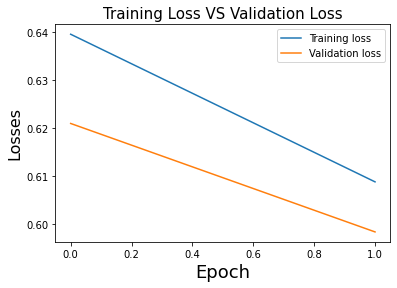

In [ ]:

import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")

print(train_losses)
print(val_losses)

plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Losses', fontsize=16)
plt.title('Training Loss VS Validation Loss', fontsize=15)

plt.legend()
plt.savefig('/content/drive/My Drive/Bibek/w10_p4-epoch1.eps')

#plt.title("Losses")

In [ ]:
model.eval()
fin_targets=[]
fin_outputs=[]
with torch.no_grad():
    c=0
    for _, data in enumerate(valid_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        emotions=data['emotion'].to(device,dtype=torch.float)
        c+=1
        try:
                      outputs = model(ids, mask, token_type_ids,emotions)
                      fin_targets.extend(targets.cpu().detach().numpy().tolist())
                      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        except EOFError:
          print(f"some error at {c}",EOFError)
outputs=fin_outputs
outputs = np.array(outputs) >= 0.5
targets=fin_targets
accuracy = metrics.accuracy_score(targets, outputs)

f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Epoch:  {epoch}, Accuracy Score on validation data = {accuracy}")

print(f"Epoch:  {epoch}, F1 Score on Validation Data (Macro) = {f1_score_macro}") 
print("____________________________________________________________\n________________________________________________________________\n\n")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[False  True]
 [ True False]
 [ True False]
 ...
 [False  True]
 [False  True]
 [False  True]]
Epoch:  1, Accuracy Score on validation data = 0.6828125
Epoch:  1, F1 Score on Validation Data (Macro) = 0.6077294685990338
____________________________________________________________
________________________________________________________________




In [ ]:
df_demo=pd.read_csv("/content/drive/MyDrive/Bibek/LIAR-DATASET ORIGINAL/final/Demo.csv")
df_demo['comment_text']=""
df_demo['comment_text']= df_demo["statement"]+". "+df_demo['sentiment_code'].astype(str)

df_demo['emotion']="["+df_demo['anger'].astype(str)+","+df_demo['disgust'].astype(str)+","\
+df_demo['fear'].astype(str)+","+df_demo['joy'].astype(str)+","+df_demo['sad'].astype(str) + "]"
for i in range(len(df_demo["emotion"])):
  try:
    df_demo["emotion"][i]=convert_to_list(df_demo["emotion"][i])
  except:
    print(i,"====",df_demo["emotion"][1])

df_demo['list']=df_demo['list'].apply(convert_to_list)


demo_set = CustomDataset(df_demo, tokenizer, MAX_LEN)

demo_params = {'batch_size': 8,
                'shuffle': False,
                'num_workers': 0
                }
demo_loader = DataLoader(demo_set, **demo_params)


with torch.no_grad():
    c=0
    for _, data in enumerate(demo_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        emotions=data['emotion'].to(device,dtype=torch.float)
        c+=1
        try:
                      outputs = model(ids, mask, token_type_ids,emotions)
                      fin_targets.extend(targets.cpu().detach().numpy().tolist())
                      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                      print(torch.sigmoid(outputs))
                      # print(emotions)


        except EOFError:
          print(f"some error at {c}",EOFError)


tensor([[0.1166, 0.8836],
        [0.1166, 0.8836],
        [0.3276, 0.6718],
        [0.3017, 0.6980],
        [0.2308, 0.7691],
        [0.2628, 0.7378],
        [0.3057, 0.6950],
        [0.1393, 0.8609]], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
